# Relazione finale

**Gruppo:** Bug Data

**Componenti del gruppo:** Jerin George Mathew, Luca Pasquini

## 1. Indice
La relazione è articolata nella seguente maniera:

-  **Analisi del dataset**
- **Specifiche hardware e software**
- **Primo job**
    - *Map reduce*
    - *Hive*
    - *Spark*
    - *Risultati*
    - *Grafici*
- **Secondo job**
    - *Map reduce*
    - *Hive*
    - *Spark*
    - *Risultati*
    - *Grafici*
- **Terzo job**
    - *Map reduce*
    - *Hive*
    - *Spark*
    - *Risultati*
    - *Grafici*
- **Conclusioni**

Verrà dunque dapprima analizzato e descritto il dataset a disposizione per poi discutere l'implementazione dei job richiesti dal progetto nelle varie tecnologie richieste dalle specifiche.

## 2. Analisi del dataset
Verranno analizzati in questa sezione i due dataset a disposizione.

In [1]:
%matplotlib inline
# Importing libraries
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
HISTORICAL_STOCK_PRICES_FILEPATH = 'dataset/historical_stock_prices.csv'
HISTORICAL_STOCKS_FILEPATH = 'dataset/historical_stocks.csv'

hsp = pd.read_csv(HISTORICAL_STOCK_PRICES_FILEPATH)
hs = pd.read_csv(HISTORICAL_STOCKS_FILEPATH)

### 2.1 `historical_stock_prices.csv`

In [8]:
hsp.shape

(20973889, 8)

Dunque il file `historical_stock_prices.csv` è composto da 209738889 righe e 8 colonne. Stampiamo ora un sottoinsieme delle righe del file `historical_stock_prices.csv`. 

In [9]:
hsp.head()

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50,11.58,8.493155,11.25,11.68,4633900,2013-05-08
1,AHH,11.66,11.55,8.471151,11.50,11.66,275800,2013-05-09
2,AHH,11.55,11.60,8.507822,11.50,11.60,277100,2013-05-10
3,AHH,11.63,11.65,8.544494,11.55,11.65,147400,2013-05-13
4,AHH,11.60,11.53,8.456484,11.50,11.60,184100,2013-05-14


Come già detto nelle specifiche, il file `historical_stock_prices.csv` è composto dai seguenti campi:
- ticker: simbolo dell’azione
- open: prezzo di apertura
- close: prezzo di chiusura
- adj_close: prezzo di chiusura “modificato”
- lowThe: prezzo minimo
- highThe: prezzo massimo
- volume: numero di transazioni
- date: data nel formato aaaa-mm-gg

Una attività preliminare all'implementazione vera e propria dei job è quella di data cleaning in cui si va a verificare la presenza di eventuali record non corretti (ad esempio contenenti valori nulli) che potrebbero essere presenti nel dataset. Verifichiamo in particolare che non siano presenti valori nulli nel file `historical_stock_prices.csv`.

In [10]:
hsp.isnull().any().any()

False

Dunque non sono presenti valori nulli. Una altra attività che possiamo effettuare è andare a verificare che vi sia un record per ogni coppia `(ticker, data)`, ovvero che non siano presenti record duplicati per un certo `ticker` in una certa data.

In [29]:
len(hsp.groupby(['ticker', 'date'])) != hsp.shape[0]

False

Dunque non sono presenti record duplicati. 

Verifichiamo ora che nei campi del dataset non vi siano valori che contengono delle virgole, cosa che potrebbe portare a degli errori in fase di lettura del csv.

Passiamo ora ad analizzare il secondo dataset, `historical_stocks.csv`.

### 2.2 `historical_stocks.csv`

In [11]:
hs.shape

(6460, 5)

In [12]:
hs.head()

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS


Dunque il secondo dataset contiene 6460 righe e 5 campi:
- ticker: simbolo dell’azione
- exchange: NYSE o NASDAQ
- name: nome dell’azienda
- sector: settore dell’azienda
- industry: industria di riferimento per l’azienda

Vediamo anche per questo secondo dataset se sono presenti valori nulli e/o duplicati e stampiamo alcune statistiche.

In [13]:
hs.isnull().any().any()

True

In [14]:
hs.isnull().any()

ticker      False
exchange    False
name        False
sector       True
industry     True
dtype: bool

Notiamo dunque come siano presenti dei campi, in particolare `sector` e `industry`  nel secondo dataset che presentano valori nulli. Stampiamo ora qualche record contenente valori nulli.

In [15]:
hs[hs['sector'].isnull() | hs['industry'].isnull()].head()

,ticker,exchange,name,sector,industry
19,ABP,NASDAQ,ABPRO CORPORATION,NaN,NaN
42,SQZZ,NASDAQ,ACTIVE ALTS CONTRARIAN ETF,NaN,NaN
62,ACT,NASDAQ,ADVISORSHARES VICE ETF,NaN,NaN
100,ABDC,NASDAQ,ALCENTRA CAPITAL CORP.,NaN,NaN
124,SMCP,NASDAQ,ALPHAMARK ACTIVELY MANAGED SMALL CAP ETF,NaN,NaN


In fase di implementazione dei job occorrerà dunque tenere a mente di ignorare i record contenenti valori nulli di `sector` e `industry`

In [16]:
len(hs['ticker']) != hs.shape[0]

False

Dunque non sono presenti valori duplicati per il file `historical_stocks.csv`.

### 2.3 `historical_stocks.csv` + `historical_stock_prices.csv`

Facciamo ora il join tra i due dataset per effettuare poi ulteriori attività di analisi.

In [17]:
df = pd.merge(hs, hsp, on = 'ticker')

In [18]:
df.shape

(20973889, 12)

In [19]:
df.head()

,ticker,exchange,name,sector,industry,open,close,adj_close,low,high,volume,date
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.00,7.95,7.95,7.90,8.50,642900,2014-04-01
1,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,7.94,8.16,8.16,7.90,8.29,228400,2014-04-02
2,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.29,8.39,8.39,8.05,8.40,105000,2014-04-03
3,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,8.50,8.69,8.69,8.32,8.70,113600,2014-04-04
4,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS,9.00,8.94,8.94,8.55,9.00,60500,2014-04-07


Ad esempio possiamo verificare se una certa compagnia dispone di più di una azione (ovvero la presenza di un un nome (`name`) di compagnia associato a più di un `ticker`).

In [20]:
df.groupby('name')['ticker'].nunique().max()

12

In [21]:
df.groupby('name')['ticker'].nunique().idxmax()

'BARCLAYS PLC'

In [22]:
list(df[df['name'] == 'BARCLAYS PLC'].groupby(['name', 'ticker']).groups.keys())

[('BARCLAYS PLC', 'BCS'),
 ('BARCLAYS PLC', 'DFVL'),
 ('BARCLAYS PLC', 'DFVS'),
 ('BARCLAYS PLC', 'DLBL'),
 ('BARCLAYS PLC', 'DLBS'),
 ('BARCLAYS PLC', 'DTUL'),
 ('BARCLAYS PLC', 'DTUS'),
 ('BARCLAYS PLC', 'DTYL'),
 ('BARCLAYS PLC', 'DTYS'),
 ('BARCLAYS PLC', 'FLAT'),
 ('BARCLAYS PLC', 'STPP'),
 ('BARCLAYS PLC', 'TAPR')]

Possiamo notare ad esempio come **_BARCLAYS PLC_** abbia ben 12 `ticker`.

Verifichiamo ora se vi sono aziende (nomi di aziende) associate a più di un settore

In [23]:
df.groupby('name')['sector'].nunique().max()

2

In [24]:
df.groupby('name')['sector'].nunique().idxmax()

'ENERGIZER HOLDINGS, INC.'

In [25]:
list(df[df['name'] == 'ENERGIZER HOLDINGS, INC.'].groupby(['name', 'sector']).groups.keys())

[('ENERGIZER HOLDINGS, INC.', 'CONSUMER NON-DURABLES'),
 ('ENERGIZER HOLDINGS, INC.', 'MISCELLANEOUS')]

Possiamo notare ad esempio come **_ENERGIZER HOLDINGS, INC._** sia associato a due settori.

Un'ulteriore controllo che possiamo effettuare sta nel verificare se sono presenti compagnie che sono quotate sia nel NYSE che nel NASDAQ

In [26]:
df.groupby('name')['exchange'].nunique().max()

2

In [27]:
df.groupby('name')['exchange'].nunique().idxmax()

'AMTRUST FINANCIAL SERVICES, INC.'

In [28]:
list(df[df['name'] == 'AMTRUST FINANCIAL SERVICES, INC.'].groupby(['name', 'exchange']).groups.keys())

[('AMTRUST FINANCIAL SERVICES, INC.', 'NASDAQ'),
 ('AMTRUST FINANCIAL SERVICES, INC.', 'NYSE')]

Notiamo come ad esempio **_AMTRUST FINANCIAL SERVICES, INC._** sia quotata in entrambe le borse.

## 3. Specifiche hardware e software

Verranno ora fornite le specifiche hardware e software della macchina locale e del cluster su cui sono stati eseguiti i job.

Si precisa come job MapReduce siano stati scritti in Python ed eseguiti utilizzando _Hadoop Streaming_(https://hadoop.apache.org/docs/r3.0.3/hadoop-streaming/HadoopStreaming.html). Hadoop Streaming è in particolare è una utility che consente agli sviluppatori di poter scrivere il codice relativo al mapper e al reducer in qualsiasi linguaggio (oltre a Java), come ad esempio Python o Scala.

Per quanto riguarda Spark, gli script sono stati scritti sempre in Python.

### 3.1 Macchina locale

#### 3.1.1 Specifiche hardware

- Intel i5 (5257U) Dual core a 2.7GHz
- 8 GB di RAM
- 128 GB di memoria secondaria (SSD)

#### 3.1.2 Specifiche software

- Java 1.8.0_181
- Python 3.7.3
- Hadoop 3.1.2
- Hive 2.3.4
- Spark 2.4.3

### 3.2 Cluster
Il cluster è stato realizzato utilizzando il servizio Dataproc di Google Cloud Platform. In particolare il cluster è composto da un nodo master e 3 nodi worker. Sia i nodi master che i nodi worker hanno le stesse specifiche hardware e software. I dataset sono stati invece salvati all'interno di un bucket di Google Cloud Storage (servizio cloud di storage di Google Cloud Platform).

#### 3.2.1 Specifiche hardware

- Macchine virtuali di tipo n1-standard-4 (4 vCPU, 15 GB di RAM)
- 500 GB di spazio su disco (hard disk)

#### 3.2.2 Specifiche software

- Python 3.6
- Hadoop 2.9.2
- Hive 2.3.4
- Spark 2.4.2

## 4. Primo Job

### 4.1 Specifiche
Implementare un job che sia in grado di generare, in ordine, le dieci azioni la cui quotazione (prezzo di chiusura) è cresciuta maggiormente dal 1998 al 2018, indicando, per ogni azione: (a) il simbolo, (b) l’incremento percentuale, (c) il prezzo minimo raggiunto, (e) quello massimo e (f) il volume medio giornaliero in quell’intervallo temporale.

### 4.2 Implementazione in MapReduce

**Mapper**

In fase di mapping estrapoliamo innanzitutto da ciascun record i campi `ticker`, `close`, `low`, `high`, `volume` e `date`.

Successivamente verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 1998-2018, per poi stampare la chiave i valori associati alla chiave. 
In particolare la chiave è composta da due campi: `ticker`, usata come chiave "primaria", e `date` usata come chiave "secondaria".

In questo modo valori che verranno ricevuti dal reducer saranno aggregati per il solo campo `ticker` e ordinati in base al campo `date` (si parla in questo caso di _secondary sort_). Questo consentirà nella fase di reduce di evitare comparazioni tra date (per trovare la data più recente e quella meno recente) ai fini del calcolo della differenza percentuale.


Il valore associato alla chiave è invece composto dai campi `close`, `low`, `high` e `volume`.

```python
class mapper:
    
    map(key, record):
        ticker, _, close, _, low, high, volume, date = record
        year = getYear(date)
        if year in range from 1998 to 2018:
            key = ticker, date
            value = close, low, high, volume
            Emit(key, value)
```

**Reducer**

Durante la fase di reduce definiamo una variabile globale `result` contenente una lista di strutture dati che chiameremo di seguito `item`, ciascuno dei quali contiene i seguenti campi:

- ticker
- differenza percentuale
- volume medio
- prezzo minimo
- prezzo massimo

In particolare ciascun `item` viene generato a partire da un data coppia (ticker,valori) in input alla fase di reduce.

Si descrive ora come vengono calcolati gli ultimi 4 campi di questa struttura dati.

In particolare, per calcolare la differenza percentuale estraiamo dalla lista `records` (si veda lo pseudocodice) il campo `close` del primo e dell'ultimo elemento della lista, essendo i valori associati ai ticker (ovvero la chiave) ordinati per data. Si procede poi al calcolo della differenza percentuale. 

Per quanto riguarda il volume medio, si estraggono i valori di `volume` associati al `ticker` corrente, si sommano tali valori e si divide il risultato per il numero di `volume`. 

Infine per poter calcolare il prezzo massimo e minimo, si estraggono i campi `low` e `high` da ciascun elemento della lista `records` per individuare poi il prezzo minimo e massimo. 

I valori così calcolati vengono poi salvati nella struttura dati `item`. A questo punto si verifica che la data meno recente del ticker corrente sia il 1998 come pure che la data più recente associata al `ticker` processato sia nell'anno 2018 (ai fini di filtrare le aziende che esistono tutt'ora oggi) e, in caso di esito positivo, la struttura dati `item` così computata viene aggiunta alla lista `result`. 

Infine, una volta computati tutti i ticker, la lista `result` viene ordinata in base al campo `percentChange` dei suoi elementi (in ordine decrescente) e vengono stampati i primi 10 di tale lista ordinata.

```python
class reducer:
    
    setup():
        result = empty list

    reduce(ticker, records):
        totalVolume = 0
        count = 0
        minLow = infinity
        maxHigh = - infinity
        
        
        # get percent change
        startingClosePrice = values.getFirstElement().getClose()
        endingClosePrice = values.getLastElement.getClose()
        percentChange = (endingClosePrice - startingClosePrice)/startingClosePrice
        
        # compute remaining values 
        for each record in records:
            totalVolume += volume value for current record
            count += 1
            minLow = min(minLow, low price value for current record)
            maxHigh = max(maxHigh, high price value for current record)
        
        # get volume
        averageVolume = totalVolume/count

        # add this item to result list
        startingDate = values.getFirstElement().getYear()
        endingDate = values.getLastElement().getYear()
        if startingDate == 1998 and endingDate == 2018:
            obj = {ticker, percentChange, minLow, maxHigh, averageVolume}
            result.append(obj)
    
    cleanup()
        sortedResult = sortByPercentChange(results, reverse=True)
        for i in range(10):
            Emit(sortedResult.getItem(i))
```

### 4.3 Implementazione in Hive

Vengono definite complessivamente 6 viste:

- `ticker_min_max_avg`, contenente il minimo valore di `low` e il massimo valore di `high` per ogni `ticker`
- `ticker_min_data` e `ticker_close_min_data`, contenenti la data meno recente e il corrispondente valore di `close` per ciascun `ticker` rispettivamente
- `ticker_max_data` e `ticker_close_max_data`, contenenti la data più recente e il corrispondente valore di `close` per ciascun `ticker` rispettivamente
- `ticker_percentuale`, che calcola l'incremento percentuale per ciascun `ticker` a partire dalle viste precedenti

Infine viene effettuato un join tra le viste `ticker_min_max_avg` e `ticker_percentuale` per ottenere il risultato richiesto.

```SQL
CREATE VIEW IF NOT EXISTS ticker_min_max_avg AS 
SELECT ticker, min(low) AS min_price, max(high) AS max_price, avg(volume) AS avg_volume 
FROM historical_stock_prices 
WHERE YEAR(data)>=1998 AND YEAR(data)<=2018 
GROUP BY ticker;

CREATE VIEW IF NOT EXISTS ticker_min_data AS 
SELECT ticker, min(TO_DATE(data)) AS min_data 
FROM historical_stock_prices 
WHERE YEAR(data)==1998 
GROUP BY ticker;

CREATE VIEW IF NOT EXISTS ticker_max_data AS 
SELECT ticker, max(TO_DATE(data)) AS max_data 
FROM historical_stock_prices 
WHERE YEAR(data)==2018 
GROUP BY ticker;

CREATE VIEW IF NOT EXISTS ticker_close_min_data AS 
SELECT h.ticker, h.data, h.close 
FROM ticker_min_data AS t, historical_stock_prices AS h 
WHERE h.ticker=t.ticker AND h.data=t.min_data;

CREATE VIEW IF NOT EXISTS ticker_close_max_data AS 
SELECT h.ticker, h.data, h.close 
FROM ticker_max_data AS t, historical_stock_prices AS h 
WHERE h.ticker=t.ticker AND h.data=t.max_data;

CREATE VIEW IF NOT EXISTS ticker_percentuale AS 
SELECT mi.ticker, ((ma.close-mi.close)/mi.close) AS inc_perc 
FROM ticker_close_max_data AS ma JOIN ticker_close_min_data AS mi ON ma.ticker=mi.ticker;

INSERT OVERWRITE LOCAL DIRECTORY 'output/'
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '\t' 
SELECT a.ticker, b.inc_perc, a.min_price, a.max_price, a.avg_volume 
FROM ticker_min_max_avg AS a join ticker_percentuale AS b on a.ticker=b.ticker 
ORDER BY b.inc_perc DESC limit 10;
```

### 4.4 Implementazione in Spark

Si descrive ora l'implementazione del job in Spark. Vengono principalmente definiti i seguenti `RDD`:

- `min_ticker_low`, contenente per ciasun ticker il prezzo di chiusura minimo
- `max_ticker_high`, contenente per ciasun ticker il prezzo di chiusura massimo
- `avg_ticker_volume`, contenente per ciascun ticker il volume medio giornaliero
- `min_data_close`, che associa ad un dato ticker il prezzo di chiusura relativo alla data meno recente
- `max_data_close`, che associa ad un dato ticker il prezzo di chiusura relativo alla data più recente

Si effettua poi il join tra `min_data_close` e `max_data_close` per ottenere `join_inc_perc`. 

A partire da `join_inc_perc` viene calcolato l'incremento percentuale per ciascun ticker (`inc_perc`). 

Infine viene fatto il join tra `inc_perc`,`avg_ticker_volume`, `min_ticker_low` e `max_ticker_high`, per poi ordinare il risultato in base all'incremento percentuale (in ordine decrescente) estraendo infine i primi 10 elementi di tale `RDD` ordinato.

```python
input = leggi tutte le righe del file historical_stock_prices.csv
        con data compresa tra il 1998 e il 2018
    
persist input in memory (and optionally on disk in case the RDD does not fit in memory) 

min_ticker_low = input.map(riga -> (ticker, low))
		              .reduceByKey(min(low1, low2))

max_ticker_high = input.map(riga -> (ticker, high))
			           .reduceByKey(max(high1, high2))

avg_ticker_volume = input.map(riga -> (ticker, (volume,1)))
                         .reduceByKey((volume1+volume2, count+1))
                         .map(riga -> (ticker, TotVolume/count))

min_data_close = input.map(riga -> (ticker, (close, data)))
                      .reduceByKey(minimo((data1,close1), (data2,close2)))
                      .filter(data.year == "1998")	

max_data_close = input.map(riga -> (ticker, (close, data)))
                      .reduceByKey(massimo((data1,close1), (data2,close2)))
                      .filter(data.year == "2018")

join_inc_perc = min_data_close.join(max_data_close)
    
inc_perc = join_inc_perc
                .map(riga -> (ticker, (maxclose-minclose)/minclose))

result = max_ticker_high
            .join(min_ticker_low)
            .join(inc_perc)
            .join(avg_ticker_volume)
            .sortBy(incremento percentuale decrescente)
            .take(10)
```

### 4.5 Risultati

Si mostra ora l'output restituito per il primo job:

```
Ticker Percent Change Min low          Max high	   Average volume
MNST  163340.387616%  0.0305979158729  70.2200012207  7347898.8208
AMZN  38328.032677%   4.14583349228    1925.0         7868702.73287
AAPL  37146.0319467%  0.482142865658   219.179992676  121398558.199
CTSH  36312.8011611%  0.145833328366   85.0999984741  6272137.93307
CELG  24924.0000849%  0.171875         147.169998169  8002695.57352
WP    24012.4988778%  0.0500000007451  96.5100021362  1270066.16934
MED   13733.2303561%  0.0936999991536  229.199996948  223768.309139
NVR   11786.7001488%  21.625           3700.0         56463.7413395
ANSS  10077.1432059%  1.375            184.949996948  482841.405197
TSCO  9508.67816472%  0.40625          97.25          1592298.53705
```




### 4.6 Grafici

Nel realizzare i grafici sono stati presi in considerazione diversi sottoinsiemi del file `historical_stock_prices.csv`:

- Un sottoinsieme del file `historical_stock_prices.csv` contenente 500000 righe (48.30 MB)
- Un sottoinsieme del file `historical_stock_prices.csv` contenente 1000000 righe (100.70 MB)
- Un sottoinsieme del file `historical_stock_prices.csv` contenente 5000000 righe (479.40 MB)
- Un sottoinsieme del file `historical_stock_prices.csv` contenente 10000000 righe (955.50 MB)
- Il file `historical_stock_prices.csv` stesso (~2 GB)
- Il file `historical_stock_prices.csv` concatenato con se stesso (~4 GB)

In [2]:
# read job timings files
FILEPATH_PREFIX = 'job-timings/'

# mapreduce jobs timings
mapreduceLocal = pd.read_csv(FILEPATH_PREFIX + 'mapreduce-local.csv')
mapreduceLocalSingleReducer = pd.read_csv(FILEPATH_PREFIX + 'mapreduce-local-single-reducer.csv')
mapreduceCluster = pd.read_csv(FILEPATH_PREFIX + 'mapreduce-cluster.csv')
mapreduceClusterSingleReducer = pd.read_csv(FILEPATH_PREFIX + 'mapreduce-cluster-single-reducer.csv')

# hive jobs timings
hiveLocal = pd.read_csv(FILEPATH_PREFIX + 'hive-local.csv',)
hiveClusterNoPartition = pd.read_csv(FILEPATH_PREFIX + 'hive-cluster-no-partition.csv')
hiveClusterPartition = pd.read_csv(FILEPATH_PREFIX + 'hive-cluster-partition.csv')

# spark jobs timings
sparkLocal = pd.read_csv(FILEPATH_PREFIX + 'spark-local.csv')
sparkLocalPersist = pd.read_csv(FILEPATH_PREFIX + 'spark-local-persist.csv')
sparkCluster = pd.read_csv(FILEPATH_PREFIX + 'spark-cluster.csv')
sparkClusterlPersist = pd.read_csv(FILEPATH_PREFIX + 'spark-cluster-persist.csv')

In [5]:
import seaborn as sns

In [15]:
# functions for drawing plots

def plotHiveWithAndWithoutPartition(jobNumber):
    hiveJobWithoutPartitioning = hiveClusterNoPartition[hiveClusterNoPartition['Job'] == jobNumber]
    hiveJobWithPartitioning = hiveClusterPartition[hiveClusterPartition['Job'] == jobNumber]

    hiveDF = pd.concat([hiveJobWithoutPartitioning, hiveJobWithPartitioning], axis=0, ignore_index=True) \
               .rename(index={0:'without partitions',1:'with partitions'})

    hiveDF = hiveDF.drop('Job', axis=1)
    fileSizes = [float(i) for i in list(hiveDF.columns)]

    f,ax = plt.subplots(figsize=(16, 8))
    sns.lineplot(x=fileSizes, y = hiveDF.loc['without partitions'], marker="o", label="without partitions")
    sns.lineplot(x=fileSizes, y = hiveDF.loc['with partitions'], marker="o", label="with partitions")
    plt.title('Hive on cluster: partitioning')
    ax.set_xlabel("File size (MB)")
    ax.set_ylabel("Time (m)")
    return


def plotSparkWithAndWithoutCaching(jobNumber):
    f,ax = plt.subplots(1, 2, figsize=(16, 8))
    
    # local machine
    sparkJobInLocalWithoutCaching = sparkLocal[sparkLocal['Job'] == jobNumber]
    sparkJobInLocalWithCaching = sparkLocalPersist[sparkLocalPersist['Job'] == jobNumber]
    sparkDFLocal = pd.concat([sparkJobInLocalWithoutCaching, sparkJobInLocalWithCaching], axis=0, ignore_index=True) \
               .rename(index={0:'without caching',1:'using cache'})
    sparkDFLocal = sparkDFLocal.drop('Job', axis=1)
    fileSizes = [float(i) for i in list(sparkDFLocal.columns)]
    sns.lineplot(x=fileSizes, y = sparkDFLocal.loc['without caching'], marker="o", label="without caching", ax=ax[0])
    sns.lineplot(x=fileSizes, y = sparkDFLocal.loc['using cache'], marker="o", label="using cache", ax=ax[0])
    ax[0].set_title("Spark on local machine: caching")
    ax[0].set_xlabel("File size (MB)")
    ax[0].set_ylabel("Time (m)")

    # cluster 
    sparkJobOnClusterWithoutCaching = sparkCluster[sparkCluster['Job'] == jobNumber]
    sparkJobOnClusterWithCaching = sparkClusterlPersist[sparkClusterlPersist['Job'] == jobNumber]
    sparkDFCluster = pd.concat([sparkJobOnClusterWithoutCaching, sparkJobOnClusterWithCaching], axis=0, ignore_index=True) \
               .rename(index={0:'without caching',1:'using cache'})
    sparkDFCluster = sparkDFCluster.drop('Job', axis=1)
    sns.lineplot(x=fileSizes, y = sparkDFCluster.loc['without caching'], marker="o", label="without caching", ax=ax[1])
    sns.lineplot(x=fileSizes, y = sparkDFCluster.loc['using cache'], marker="o", label="using cache", ax=ax[1])
    ax[1].set_title("Spark on cluster: caching")
    ax[1].set_xlabel("File size (MB)")
    ax[1].set_ylabel("Time (m)")
    return

    
def compareOnLocalMachine(jobNumber):
    mapReduceInLocal = mapreduceLocal[mapreduceLocal['Job'] == jobNumber]
    hiveInLocal = hiveLocal[hiveLocal['Job'] == jobNumber]
    sparkJobInLocalWithCaching = sparkLocalPersist[sparkLocalPersist['Job'] == jobNumber]
    jobOnLocalMachine = pd.concat([mapReduceInLocal, hiveInLocal, sparkJobInLocalWithCaching], axis=0, ignore_index=True) \
               .rename(index={0:'mapreduce',1:'hive', 2:'spark'})
    jobOnLocalMachine = jobOnLocalMachine.drop('Job', axis=1)
    fileSizes = [float(i) for i in list(jobOnLocalMachine.columns)]
    f,ax = plt.subplots(figsize=(16, 8))
    sns.lineplot(x=fileSizes, y = jobOnLocalMachine.loc['mapreduce'], marker="o", label="mapreduce")
    sns.lineplot(x=fileSizes, y = jobOnLocalMachine.loc['hive'], marker="o", label="hive")
    sns.lineplot(x=fileSizes, y = jobOnLocalMachine.loc['spark'], marker="o", label="spark")

    plt.title('Comparing MapReduce, Hive and Spark on local machine')
    ax.set_xlabel("File size (MB)")
    ax.set_ylabel("Time (m)")
    return

    
def compareOnCluster(jobNumber):
    mapReduceOnCluster = mapreduceCluster[mapreduceCluster['Job'] == jobNumber]
    hiveOnCluster = hiveClusterPartition[hiveClusterPartition['Job'] == jobNumber]
    sparkJobOnClusterWithCaching = sparkClusterlPersist[sparkClusterlPersist['Job'] == jobNumber]
    jobOnCluster = pd.concat([mapReduceOnCluster, hiveOnCluster, sparkJobOnClusterWithCaching], axis=0, ignore_index=True) \
               .rename(index={0:'mapreduce',1:'hive', 2:'spark'})
    jobOnCluster = jobOnCluster.drop('Job', axis=1)
    fileSizes = [float(i) for i in list(jobOnCluster.columns)]

    f,ax = plt.subplots(figsize=(16, 8))
    sns.lineplot(x=fileSizes, y = jobOnCluster.loc['mapreduce'], marker="o", label="mapreduce")
    sns.lineplot(x=fileSizes, y = jobOnCluster.loc['hive'], marker="o", label="hive")
    sns.lineplot(x=fileSizes, y = jobOnCluster.loc['spark'], marker="o", label="spark")

    plt.title('Comparing MapReduce, Hive and Spark on cluster')
    ax.set_xlabel("File size (MB)")
    ax.set_ylabel("Time (m)")
    return


def compareLocalAndCluster(jobNumber):
    f,ax = plt.subplots(1, 3, figsize=(16, 8))

    # mapreduce
    mapReduceInLocal = mapreduceLocal[mapreduceLocal['Job'] == jobNumber]
    mapReduceOnCluster = mapreduceCluster[mapreduceCluster['Job'] == jobNumber]
    mapReduceTimings = pd.concat([mapReduceInLocal, mapReduceOnCluster], axis=0, ignore_index=True) \
               .rename(index={0:'local',1:'cluster'})
    mapReduceTimings = mapReduceTimings.drop('Job', axis=1)
    fileSizes = [float(i) for i in list(mapReduceTimings.columns)]
    
    sns.lineplot(x=fileSizes, y = mapReduceTimings.loc['local'], marker="o", label="on local machine", ax=ax[0])
    sns.lineplot(x=fileSizes, y = mapReduceTimings.loc['cluster'], marker="o", label="on cluster", ax=ax[0])
    ax[0].set_title("Mapreduce")
    ax[0].set_xlabel("File size (MB)")
    ax[0].set_ylabel("Time (m)")


    # hive 
    hiveInLocal = hiveLocal[hiveLocal['Job'] == jobNumber]
    hiveOnCluster = hiveClusterPartition[hiveClusterPartition['Job'] == jobNumber]
    hiveTimings = pd.concat([hiveInLocal, hiveOnCluster], axis=0, ignore_index=True) \
               .rename(index={0:'local',1:'cluster'})
    hiveTimings = hiveTimings.drop('Job', axis=1)
    sns.lineplot(x=fileSizes, y = hiveTimings.loc['local'], marker="o", label="on local machine", ax=ax[1])
    sns.lineplot(x=fileSizes, y = hiveTimings.loc['cluster'], marker="o", label="on cluster", ax=ax[1])
    ax[1].set_title("Hive")
    ax[1].set_xlabel("File size (MB)")
    ax[1].set_ylabel("Time (m)")

    # spark
    sparkJobInLocalWithCaching = sparkLocalPersist[sparkLocalPersist['Job'] == jobNumber]
    sparkJobOnClusterWithCaching = sparkClusterlPersist[sparkClusterlPersist['Job'] == jobNumber]
    sparkTimings = pd.concat([sparkJobInLocalWithCaching, sparkJobOnClusterWithCaching], axis=0, ignore_index=True) \
               .rename(index={0:'local',1:'cluster'})
    sparkTimings = sparkTimings.drop('Job', axis=1)
    sns.lineplot(x=fileSizes, y = sparkTimings.loc['local'], marker="o", label="on local machine", ax=ax[2])
    sns.lineplot(x=fileSizes, y = sparkTimings.loc['cluster'], marker="o", label="on cluster", ax=ax[2])
    ax[2].set_title("Spark")
    ax[2].set_xlabel("File size (MB)")
    ax[2].set_ylabel("Time (m)")
    return

#### 4.6.1 Hive: partizionamento
Un miglioramento delle prestazioni del job in Hive è stato ottenuto effettuando un partizionamento della tabella contenente il file `historical_stock_prices.csv` basato sull'anno. I risultati mostrati di seguito riportano le tempistiche ottenute eseguendo il job con Hive su cluster con e senza partizionamento della tabella.

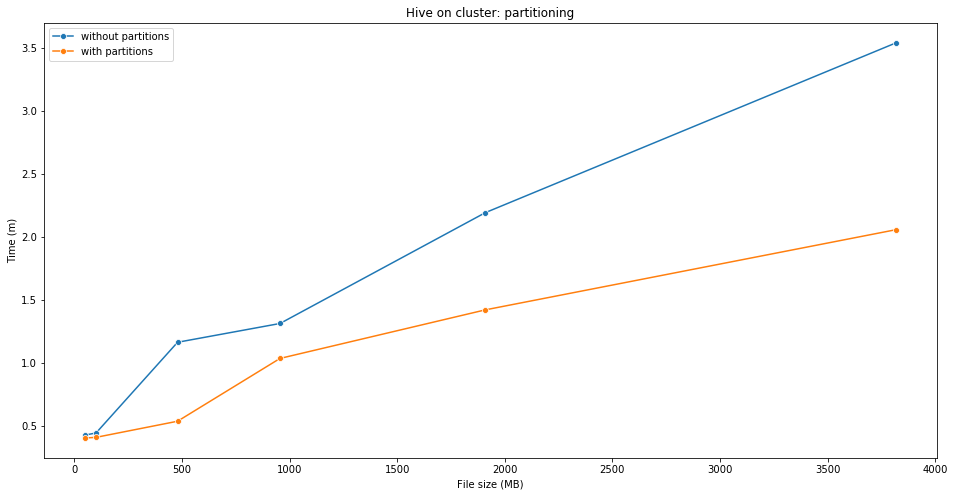

In [10]:
plotHiveWithAndWithoutPartition(1)

#### 4.6.2 Spark: caching
In Spark invece è stato possibile migliorare le prestazioni del job mantenendo in memoria, con il metodo `persist()` di Spark (come già riportato nello pseudocodice), l'RDD che veniva impiegato nelle trasformazioni e nelle azioni successive. Si riportano di seguito i risultati ottenuti in locale e su cluster.

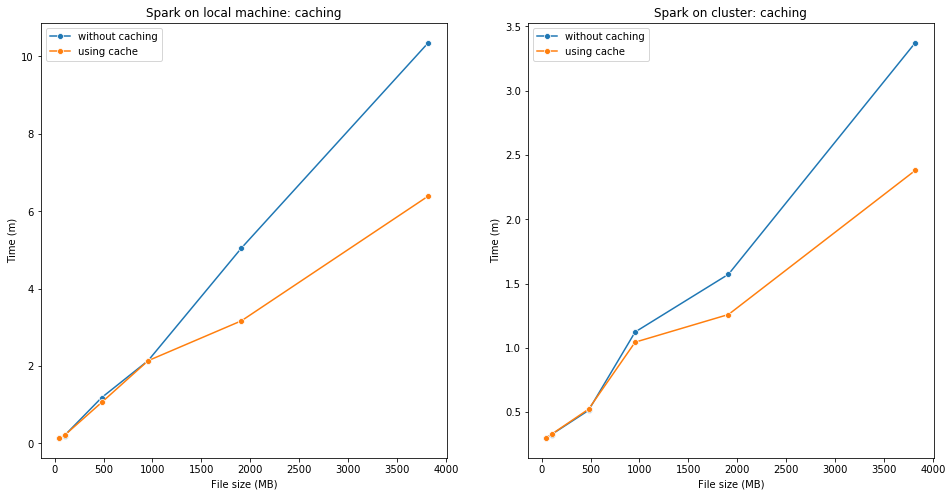

In [11]:
plotSparkWithAndWithoutCaching(1)

#### 4.6.4 Confronto tra MapReduce, Spark e Hive in locale

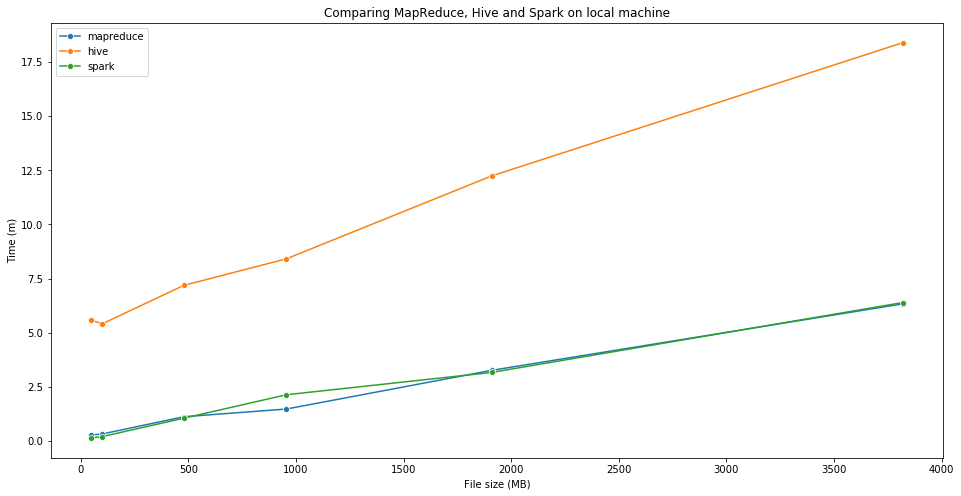

In [16]:
compareOnLocalMachine(1)

Notiamo come in locale il tempo necessario per eseguire il job su MapReduce e Spark sia pressoché lo stesso, mentre si rende necessario molto più tempo per eseguire il job su Hive.

#### 4.6.5 Confronto tra MapReduce, Spark e Hive su cluster

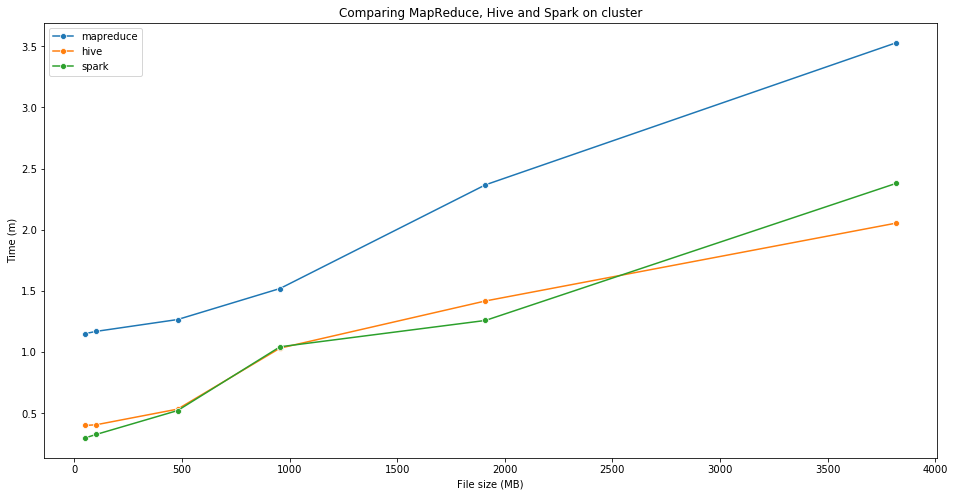

In [13]:
compareOnCluster(1)

#### 4.6.6 Macchina locale vs cluster

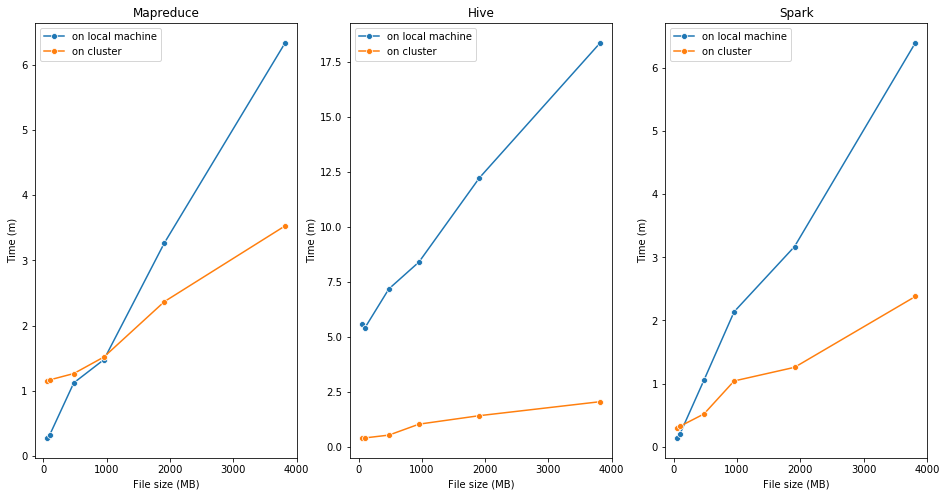

In [14]:
compareLocalAndCluster(1)

Possiamo notare come sia per MapReduce che per Spark si abbiano inizialmente delle prestazioni migliori in locale rispetto al cluster, mentre per moli di dati via via sempre più grandi si ottengono delle tempistiche migliori su cluster. Le migliori prestazioni in locale su file di piccole dimensioni è probabilmente dovuto al fatto che su cluster l'overhead di comunicazione incide maggiormente sulla tempistica finale rispetto al numero di dati da processare.

## 5. Secondo Job

### 5.1 Specifiche
Realizzare un job che sia in grado di generare, per ciascun settore, il relativo “trend” nel periodo 2004-2018 ovvero un elenco contenente, per ciascun anno nell’intervallo: (a) il volume complessivo del settore, (b) la percentuale di variazione annuale (differenza percentuale arrotondata tra la quotazione di fine anno e quella di inizio anno) e (c) la quotazione giornaliera media. N.B.: volume e quotazione di un settore si ottengono sommando i relativi valori di tutte le azioni del settore.

### 5.2 Implementazione in MapReduce

**Mapper**

Leggiamo dapprima, utilizzando la _Distributed Cache_ (https://hadoop.apache.org/docs/r3.0.0/api/org/apache/hadoop/filecache/DistributedCache.html) il file `historical_stocks.csv`, per poi definire, a partire dallo stesso file, una struttura dati (`tickerToSectorMap`) che associa a ciascun `ticker` il corrispondente settore (escludendo i `ticker` privi di un corrispondente settore).

La _Distributed Cache_ in particolare consente poter mettere a disposizione dei nodi worker, ovvero mapper e reducer, dei file che possono poi essere letti ai fini di svolgere le attività di map e reduce rispettivamente. 

La struttura dati `tickerToSectorMap` così creata verrà usata poi in fase di mapping per poter effettuare il "join" con i record del file `historical_stock_prices.csv` associando a ciascun record il settore del `ticker` presente nel record stesso.

In fase di mapping estrapoliamo da ciascun record i campi `ticker`, `close`, `volume` e `date`, verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 2004-2018 per poi stampare la coppia chiave valore associata al record in questione.

In particolare la chiave è composta da tre campi: `sector`, usata come chiave "primaria", `ticker` e `date`, dove questi ultimi due campi vengono usati per poter effettuare il _secondary sort_, in maniera tale che i valori per uno stesso settore siano ordinati (e aggregati) per `sector` e a parità di `sector` siano ordinati per `ticker` e `data`.

Grazie a questo ordinamento delle chiavi sarà poi possibile in fase di reduce poter calcolare gli incrementi percentuali associati a ciascun settore senza dover effettuare una comparazione tra date (al fine di trovare la data più recente e quella meno recente).

Il valore associato alla chiave è invece composta dai campi `close` e `volume`.

```python
class mapper:
    
    setup():
        read the historical_stocks.csv file from the Distributed Cache
        tickerToSectorMap = map which associate a (non null) sector for each ticker in historical_stocks.csv
    
    map(key, record):
        ticker, _, close, _, _, _, volume, date = record
        year = getYear(date)
        if year in range from 2004 to 2018 and 
           ticker has a corresponding sector in tickerToSectorMap:
            sector = ticker's corresponding sector
            key = sector, ticker, date
            value = close, volume
            Emit(key, value)
```

**Reducer**

Durante la fase di reduce, per ciascun settore definiamo una serie di strutture dati (nello specifico mappe chiave valore) finalizzate al calcolo del volume complessivo, della quotazione giornaliera media e dell'incremento percentuale per settore per ciascun anno:

Verrà ora descritto come vengono calcolati questi tre valori.

Per calcolare la differenza percentuale si sfrutta l'ordinamento dei valori associati a ciascun settore per poter estrarre i prezzi di chiusura meno recenti e più recenti di ciascun `ticker` in ciascun anno. Si sommano poi tali valori per ciascun anno per ottenere la "quotazione di partenza" annua e la "quotazione finale" annua del settore. A partire da questi ultimi due valori si calcola infine la differenza percentuale. 

Per il calcolo della quotazione giornaliera media in un dato anno invece si sommano dapprima i prezzi di chiusura dei ticker relativi stessa data. Si effettua poi una media aritmetica dei risultati così ottenuti.

Infine per quanto riguarda il volume complessivo annuo, si scandiscono i record del settore in questione, sommando tra loro i valori di `volume` relativi allo stesso anno.

```python
class reducer:

    reduce(sector, records):
        yearToStartingCloseValueMap = empty map
        yearToEndingCloseValueMap = empty map
        yearToTotalVolumeMap = empty map
        yearToTotalCloseValue = empty nested map
        
        for record in records:
            day = get date field from the current record
            year = get year value from the day variable
            if the record's corresponding ticker has changed from the previous record:
                yearToEndingCloseValueMap[previous year] += close field taken from the previous record
                yearToStartingCloseValueMap[year] += close field taken from the current record
            yearToTotalVolumeMap[year] += volume field taken from the current record
            yearToTotalCloseValue[year][date] += close
            
        percentChange = empty map
  
        for each year from 2004 to 2018:
            difference = yearToEndingCloseValueMap[year] - yearToStartingCloseValueMap[year]
            percentChange[year] = difference/yearToStartingCloseValueMap[year]
            count = number of date keys in yearToTotalCloseValue[year][date]
            dailyCloseAverage[year] = yearToTotalCloseValue[year][date]/count
            Emit(sector, totalVolume[year], percentChange[year], dailyCloseAverage[year])
```

### 5.3 Implementazione in Hive

Viene dapprima effettuato un join tra le tabelle che contengono i file `historical_stock_prices.csv` e `historical_stocks.csv` mettendo la tabella che contiene i record giornalieri a destra dell'operatore di join per migliorare l'efficienza dell'operazione. Durante l'operazione di join vengono filtrati i ticker che non sono associati ad alcun settore.
Vengono in seguito definite 7 viste:

- `sector_data_volume`, contenente il volume complessivo annuo di ciascun settore;
- `sector_data_min_max`, che contiene per ciascun ticker e ciascun anno la data meno recente e quella più recente;
- `sector_data_close_min` e `sector_data_close_max`, che contengono il prezzo di chiusura complessivo associato alla data meno recente e quella più recente per ciascun settore in ciascun anno;
- `sector_data_close`, che contiene l'incremento percentuale per ciascun settore in ciascun anno;
- `sector_data_sum_close`, che contiene la somma dei prezzi di chiusura di uno stesso giorno per tutti i ticker di uno stesso settore
- `sector_data_avg_close`, contenente la quotazione giornaliera media per ciascun settore in ciascun anno

Viene infine effettuato il join tra le tabelle `sector_data_avg_close`, `sector_data_close`, `sector_data_volume` per ottenere l'output richiesto.


```SQL
CREATE TABLE IF NOT EXISTS first_pricipal_table AS 
SELECT hs.sector, hsp.ticker, hsp.data, hsp.close, hsp.volume 
FROM historical_stock AS hs JOIN historical_stock_prices AS hsp ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2004 AND YEAR(hsp.data)<=2018 AND hs.sector!='N/A';

CREATE VIEW IF NOT EXISTS sector_data_volume AS 
SELECT sector, YEAR(data) AS anno, SUM(volume) AS somma_volume 
FROM first_pricipal_table 
GROUP BY sector, YEAR(data);

CREATE VIEW IF NOT EXISTS sector_data_min_max AS 
SELECT sector, ticker, min(TO_DATE(data)) AS min_data, max(TO_DATE(data)) AS max_data 
FROM first_pricipal_table 
GROUP BY sector, ticker, YEAR(data);

CREATE VIEW IF NOT EXISTS sector_data_close_min AS 
SELECT b.sector, YEAR(b.min_data) AS anno, SUM(a.close) AS min_close 
FROM first_pricipal_table AS a, sector_data_min_max AS b 
WHERE a.sector=b.sector AND a.data=b.min_data AND b.ticker=a.ticker 
GROUP BY b.sector, YEAR(b.min_data);

CREATE VIEW IF NOT EXISTS sector_data_close_max AS 
SELECT b.sector, YEAR(b.max_data) AS anno, SUM(a.close) AS max_close 
FROM first_pricipal_table AS a, sector_data_min_max AS b 
WHERE a.sector=b.sector AND a.data=b.max_data AND b.ticker=a.ticker 
GROUP BY b.sector, YEAR(b.max_data);

CREATE TABLE IF NOT EXISTS sector_data_close AS 
SELECT mi.sector, mi.anno, ROUND((ma.max_close-mi.min_close)/mi.min_close*100,2) AS perc_var_anno 
FROM sector_data_close_min AS mi, sector_data_close_max AS ma 
WHERE mi.sector=ma.sector AND mi.anno=ma.anno
ORDER BY sector, anno; 

CREATE VIEW IF NOT EXISTS sector_data_sum_close AS 
SELECT sector, data, SUM(close) AS somma 
FROM first_pricipal_table 
GROUP BY sector, data;

CREATE VIEW IF NOT EXISTS sector_data_avg_close AS 
SELECT sector, YEAR(data) AS anno, AVG(somma) AS media 
FROM sector_data_sum_close 
GROUP BY sector, YEAR(data);

INSERT OVERWRITE LOCAL DIRECTORY 'output/'
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '\t' 
SELECT a.sector, a.anno, c.somma_volume, b.perc_var_anno, a.media 
FROM sector_data_avg_close AS a, sector_data_close AS b, sector_data_volume AS c 
WHERE a.sector=b.sector AND b.sector=c.sector AND a.anno=b.anno AND c.anno=b.anno
ORDER BY sector, anno;
```

### 5.4 Implementazione in Spark


Si descrive ora l'implementazione del job in Spark. Vengono principalmente definiti i seguenti `RDD`:

- `sum_volume`, che contiene per ciascun settore, in ciascun anno, il volume complessivo;
- `sum_close_avg`, che contiene per ciascun settore, in ciascun anno, la quotazione giornaliera media;
- `min_data_close`, che contiene per ciascun settore, in ciascun anno, la quotazione relativa alla data meno recente;
- `max_data_close`, che contiene per ciascun settore, in ciascun anno, la quotazione relativa alla data più recente;

Si effettua poi il join tra `min_data_close` e `max_data_close` per ottenere `join_inc_perc`. 

A partire da `join_inc_perc` viene calcolato l'incremento percentuale per ciascun settore in ciascun anno (`inc_perc`). 

Infine viene fatto il join tra `inc_perc`,`sum_close_avg` e  `sum_volume` per ottenere l'output richiesto.

```python
hsp = RDD contenente il dataset historical_stock_prices.csv
      con i record relativi agli anni nell'intervallo 2004-2018
hs = RDD contenente il dataset historical_stocks.csv,
     filtrando i record in cui il campo sector assume valore "N/A"
    
join_hsp_hs = join tra gli RDD hs e hsp

persist join_hsp_hs in memory (and optionally on disk in case the RDD does not fit in memory) 

sum_volume = join_hsp_hs.map(riga -> ((sector, anno), volume)) \
                        .reduceByKey(volume1+volume2)

sum_close_avg = join_hsp_hs.map(lambda line: ((sector, date), close)) \
                           .reduceByKey(close1+close2) \
                           .map(lambda line: ((sector, anno), (somma_close, 1))) \
                           .reduceByKey(riga -> (somma_close1+somma_close2, count+1))
                           .map(riga -> (sector, (somma_close/count))

min_data_close = join_hsp_hs.map(riga -> ((ticker, sector, anno), (close, data)))
                            .reduceByKey(minimo((data1,close1), (data2,close2)))
                            .map(riga -> ((settore, anno), close_minimo)) \
                            .reduceByKey(close_minimo1+close_minimo2)

max_data_close = join_hsp_hs.map(riga -> ((ticker, sector, anno), (close, data)))
                            .reduceByKey(massimo((data1,close1), (data2,close2)))
                            .map(riga -> ((settore, anno), close_massimo)) \
                            .reduceByKey(close_massimo1+close_massimo2)

join_inc_perc = min_data_close.join(max_data_close)
                                
inc_perc = join_inc_perc.map(riga -> (ticker, (maxclose-minclose)/minclose * 100 round 2))

result = inc_perc.join(sum_close_avg).join(sum_volume).sortBy(ticker)

```

### 5.5 Risultati
Si riportano le prime 16 righe dell'output prodotto per il secondo job:

```
Sector			 Year  Total Volume  Percent Change	Daily mean close price
BASIC  INDUSTRIES  2004  30767395827   0.228150473063    2865.87369398
BASIC  INDUSTRIES  2005  37457588379   0.0633341791619   4367.6822369
BASIC  INDUSTRIES  2006  50413342778   0.294700074157    7110.07082055
BASIC  INDUSTRIES  2007  67640775192   0.185667471534    9211.13392303
BASIC  INDUSTRIES  2008  104336790359  -0.050131389643   7124.09400267
BASIC  INDUSTRIES  2009  113161759706  0.0348287578952   4727.91920472
BASIC  INDUSTRIES  2010  96267427694   0.217900355607    6126.05228338
BASIC  INDUSTRIES  2011  93277620675   -0.586007636167   8535.55187455
BASIC  INDUSTRIES  2012  79648935208   -0.687885248968   8694.81899382
BASIC  INDUSTRIES  2013  81167036326   0.103226361955    28486.4249861
BASIC  INDUSTRIES  2014  82010502666   -0.719021325857   24380.2074047
BASIC  INDUSTRIES  2015  95592658398   -0.481011719633   9538.71135927
BASIC  INDUSTRIES  2016  120096921114  0.138293577492    7721.85529589
BASIC  INDUSTRIES  2017  100051884333  0.152790107615    9101.40840867
BASIC  INDUSTRIES  2018  61239875499   -0.0307952148952  9883.13711755
```

### 5.6 Grafici

## 6. Terzo job

### 6.1 Specifiche
Realizzare un job in grado di generare coppie di aziende di settori diversi le cui azioni, negli ultimi 3 anni, hanno avuto lo stesso trend in termini di variazione annuale indicando le aziende e il trend comune (es. Apple, Fiat, 2016:-1%, 2017:+3%, 2018:+5%).

### 6.2 Implementazione in MapReduce

Per realizzare il questo job è stato necessario definire una applicazione MapReduce composta da due job. Vengono descritti in seguito a parole e tramite pseudocodice le funzionalità svolte da ciascun mapper e reducer dell'applicazione MapReduce realizzata.

**Primo mapper**:

Leggiamo dapprima, utilizzando la _Distributed Cache_, il file `historical_stocks.csv`, per poi definire, a partire dallo stesso file, una struttura dati `tickerToNameMap` che associa a ciascun `ticker` il nome della corrispondente compagnia.

La struttura dati `tickerToCompanyNameMap` così creata verrà poi usata per poter effettuare in seguito il "join" con i record in input al mapper, associando a ciascun record il nome della compagnia associata al `ticker` presente nel record stesso.

Successivamente, in fase di mapping, estrapoliamo da ciascun record i campi `ticker`, `close` e `date`, verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 2016-2018 per poi stampare la coppia chiave valore per il record in esame. 

In particolare la chiave è composta da tre campi: `name`, usata come chiave "primaria", `ticker` e `date`, dove questi ultimi due campi vengono usati per poter effettuare il _secondary sort_, in maniera tale che i valori per uno stesso nome di compagnia siano ordinati (e aggregati) per `name` e a parità di `name` siano ordinati per `ticker` e `data`.

Grazie a questo ordinamento delle chiavi sarà poi possibile in fase di reduce poter calcolare gli incrementi percentuali associati a ciascun nome di azienda senza dover effettuare una comparazione tra date (al fine di trovare la data più recente e quella meno recente).

Il valore associato alla chiave corrisponde al campo `close` del record.

```python
class mapper:
    
    setup():
        read the historical_stocks.csv file from the Distributed Cache
        tickerToCompanyNameMap = map which associate the respective company name for each ticker in historical_stocks.csv
    
    map(key, record):
        ticker, _, close, _, _, _, _, date = data
        year = getYear(date)
        if year in range from 2016 to 2018 and 
           ticker has a corresponding name in tickerToNameMap:
            companyName = ticker's corresponding name
            key = name, ticker, date
            value = close
            Emit(key, value)
```

**Primo reducer**

Leggiamo dapprima, utilizzando la _Distributed Cache_, il file `historical_stocks.csv`, per poi definire, a partire dallo stesso file, una struttura dati `companyNameToSectorMap` che associa a ciascuna compagnia il settore corrispondente (si ricorda come una compagnia può essere associata a più di un settore).

La struttura dati `companyNameToSectorMap` così creata verrà poi usata per poter effettuare il "join" con le coppie chiave-valore in input al reducer, associando a ciascuna coppia chiave-valore in input il settore della compagnia in esame.

Fatto ciò, in fase di reduce, per ciascun nome di compagnia, definiamo una serie di strutture dati (nello specifico mappe chiave valore) finalizzate al calcolo dell'incremento percentuale per settore per ciascun anno nell'intervallo 2016-2018

In particolare, per calcolare la differenza percentuale si sfrutta l'ordinamento dei valori associati a ciascun nome di compagnia per poter estrarre i prezzi di chiusura meno recenti e più recenti di ciascun `ticker` in ciascun anno. Si sommano poi tali valori per ciascun anno per ottenere la "quotazione di partenza" annua e la "quotazione finale" annua per quella particolare compagnia. A partire da questi ultimi due valori si calcola infine la differenza percentuale.

```python
class reducer:
    
    setup():
        read the historical_stocks.csv file from the Distributed Cache
        companyNameToSectorMap = map which associate the respective sector(s) for each company name in historical_stocks.csv
    
    reduce(companyName, records):
        sectorList = companyNameToSectorMap[companyName]
        yearToStartingCloseValueMap = empty map
        yearToEndingCloseValueMap = empty map
        
        for record in records:
            day = get date field from the current record
            year = get year value from the day variable
            if the record's corresponding ticker has changed from the previous record:
                yearToEndingCloseValueMap[previous year] += close field taken from the previous record
                yearToStartingCloseValueMap[year] += close field taken from the current record
            
        percentChange = empty map
  
        for each year from 2016 to 2018:
            difference = yearToEndingCloseValueMap[year] - yearToStartingCloseValueMap[year]
            percentChange[year] = difference/yearToStartingCloseValueMap[year]
        
        for each sector in sectorList:
            Emit(percentChange[2016], percentChange[2017], percentChange[2018], name, sector)
```

**Secondo mapper**

Questo secondo mapper estrae da ciascun record i campi prodotti dal precedente reducer e produce in output una coppia chiave valore dove la chiave corrisponde alla tripla di differenze percentuali relative al 2016, 2017 e 2018, mentre il valore corrisponde al nome della compagnia e il settore corrispondente.

In questo modo, in fase di reduce verranno aggregati sotto la stessa chiave (ovvero tripla di differenze percentuali) tutte le compagnie che hanno lo stesso "trend" in termini di differenza percentuale.

```python
class mapper:
    
    map(key, record):
        percentChange2016, percentChange2017, percentChange2018, companyName, sector = record
        key = percentChange2016, percentChange2017, percentChange2018
        value = companyName, sector
        Emit(key, value)
```

**Secondo reducer**

In fase di reducer effettuaimo una scansione (in realtà due scansioni) dei record per poi stampare le coppie di aziende che hanno la stessa tripla e settori differenti.


```python
class reducer:

    
    reduce(percentTriplet, records):
        companyPairList = list of company which have different sector and the same "trend" (in other words the same percent change triplet for 2016, 2017, 2018) 
        
        for each companyPair in companyPairList:
            emit(companyPair)
```

### 6.3 Implementazione in Hive

Viene dapprima effettuato un join tra le tabelle che contengono i file `historical_stock_prices.csv` e `historical_stocks.csv` mettendo la tabella che contiene i record giornalieri a destra dell'operatore di join per migliorare l'efficienza dell'operazione. Durante l'operazione di join vengono filtrati i ticker che non sono associati ad alcun settore.
Vengono in seguito definite 5 viste:

- `name_data_min_max`, contenente la data più recente e meno recente per ogni ticker in ciascun anno;
- `name_data_close_min` e `name_data_close_max`, che contengono il prezzo di chiusura associato alla data meno recente e quella più recente rispettivamente per ciascuna compagnia in ciascun anno;
- `name_anno_close`, che contiene l'incremento percentuale per ciascuna compagnia in ciascun anno;
- `name_anno_close_JOIN`, contenente coppie di compagnie di differenti settori che hanno la stessa differenza percentuale per un dato anno.

Infine si effettua un self join di `name_anno_close_JOIN` per poter individuare coppie di aziende che appartengono a differenti settori e hanno gli stessi valori di differenza percentuale per gli anni 2016, 2017 e 2018.

```SQL
CREATE TABLE IF NOT EXISTS table_ex3 AS 
SELECT hs.name, hs.sector, hsp.data, hsp.close, hs.ticker
FROM historical_stock AS hs JOIN historical_stock_prices AS hsp on hsp.ticker=hs.ticker
WHERE YEAR(data)>=2016 AND YEAR(data)<=2018 AND hs.sector!='N/A';

CREATE VIEW IF NOT EXISTS name_data_min_max AS 
SELECT name, ticker, sector, YEAR(data) AS anno, min(TO_DATE(data)) AS min_data, max(TO_DATE(data)) AS max_data 
FROM table_ex3 
GROUP BY name, ticker, sector, YEAR(data);

CREATE VIEW IF NOT EXISTS name_data_close_min AS 
SELECT b.name, a.sector, YEAR(b.min_data) AS anno, SUM(a.close) AS min_close 
FROM table_ex3 AS a, name_data_min_max AS b 
WHERE a.sector=b.sector AND a.data=b.min_data AND b.ticker=a.ticker
GROUP BY b.name,a.sector, YEAR(b.min_data);

CREATE VIEW IF NOT EXISTS name_data_close_max AS 
SELECT b.name, a.sector, YEAR(b.max_data) AS anno, SUM(a.close) AS max_close 
FROM table_ex3 AS a, name_data_min_max AS b 
WHERE a.sector=b.sector AND a.data=b.max_data AND a.ticker=b.ticker
GROUP BY b.name, a.sector, YEAR(b.max_data); 

CREATE TABLE IF NOT EXISTS name_anno_close AS 
SELECT mi.name, mi.sector, mi.anno, ROUND(((ma.max_close-mi.min_close)/mi.min_close *100 ) , 0) AS perc_var_anno
FROM name_data_close_min AS mi, name_data_close_max AS ma
WHERE mi.name=ma.name AND mi.anno=ma.anno AND mi.sector=ma.sector
ORDER BY name, sector, anno;

CREATE TABLE IF NOT EXISTS name_anno_close_JOIN AS
SELECT n1.name AS name1, n2.name AS name2, n1.anno, n1.perc_var_anno
FROM name_anno_close AS n1, name_anno_close AS n2
WHERE n1.name!=n2.name AND n1.sector!=n2.sector AND n1.anno=n2.anno AND n1.perc_var_anno=n2.perc_var_anno;

INSERT OVERWRITE LOCAL DIRECTORY 'output/'
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '\t'
SELECT DISTINCT a.name1, a.name2, a.anno AS anno1, a.perc_var_anno AS perc_var_anno1, b.anno AS anno2, b.perc_var_anno AS perc_var_anno2, c.anno AS anno3, c.perc_var_anno AS perc_var_anno3
FROM name_anno_close_JOIN AS a, name_anno_close_JOIN AS b, name_anno_close_JOIN AS c
WHERE a.name1=b.name1 AND b.name1=c.name1 AND a.name2=b.name2 AND b.name2=c.name2 AND a.anno=2016 AND b.anno=2017 AND c.anno=2018
ORDER BY name1, name2;
```

### 6.4 Implementazione in Spark

Si descrive ora l'implementazione del job in Spark. Vengono principalmente definiti i seguenti `RDD`:

- `min_data_close`, che contiene per ciascuna compagnia, in ciascun anno, la quotazione relativa alla data meno recente;
- `max_data_close`, che contiene per ciascuna compagnia, in ciascun anno, la quotazione relativa alla data più recente;

A partire dai due RDD definiti in precedenza viene definito un nuovo RDD chiamato `inc_perc` che ha come chiave la coppia name, sector e come valore l'incremento percentuale annuo.

Successivamente viene definito un RDD chiamato `three_row` che contiene per ciascuna compagnia il relativo settore e gli incrementi percentuali relativi al 2016, al 2017 e al 2018.

Infine, una volta filtrato da `three_row` le compagnie che hanno valori nulli di incrementi percentuali per anche solo uno degli anni nell'intervallo 2016-2018, viene effettuato un self join di `three_row` mantenendo solo le coppie di aziende che hanno settori differenti e stessi incrementi percentuali per gli anni che vanno dal 2016 al 2018

```python
hsp = RDD contenente il dataset historical_stock_prices.csv,
      con i record relativi ai soli anni nell'intervallo 2016-2018
hs = RDD contenente il dataset historical_stocks.csv,
     filtrando i record in cui il campo sector assume valore "N/A"
    
join_hsp_hs = join tra gli RDD hs e hsp

persist join_hsp_hs in memory (and optionally on disk in case the RDD does not fit in memory)

min_data_close = join_hsp_hs.map(riga -> ((ticker, sector, name, anno), (close, data)))
                            .reduceByKey(minimo((data1,close1), (data2,close2)))
                            .map(riga -> ((settore, name, anno), close_minimo)) 
                            .reduceByKey(close_minimo1+close_minimo2)

max_data_close = join_hsp_hs.map(riga -> ((ticker, sector, name, anno), (close, data)))
                            .reduceByKey(massimo((data1,close1), (data2,close2)))
                            .map(riga -> ((settore, name, anno), close_massimo)) 
                            .reduceByKey(close_massimo1+close_massimo2)

join_inc_perc = min_data_close.join(max_data_close)

inc_perc = join_inc_perc.map(riga -> (ticker, (maxclose-minclose)/minclose * 100 round 0)) 

three_row = inc_perc.map(riga -> ((name,sector), ([(anno,incremento percentuale)])))
                    .reduceByKey(([(anno1,incremento percentuale1) concat (anno2,incremento percentuale2)]))
                           
three_row_clean = three_row.filter(riga -> filtro le righe che contengono valori non nulli di incremento percentuali negli anni 2016 2017 e 2018)

three_row_clean_order = three_row_clean.map(riga -> ordino la lista [anno1,inc_perc1,anno2,inc_perc2,anno3,inc_perc3])
                           
result = three_row_clean_order.map(riga -> ([anno1,inc_perc1,anno2,inc_perc2,anno3,inc_perc3]),((name,sector)))
		 .reduceByKey((name1,sector1)+(name2,sector2))
         .filter(len([name,sector])>=2) # filtro le tuple per considerare solo le coppie di aziende
         .filter(sector1!=sector2) 
```

### 6.5 Risultati

Si mostra ora l'output prodotto per il terzo job

```
First company                 Second company                            2016        2017        2018
STURM, RUGER & COMPANY, INC.  LINCOLN EDUCATIONAL SERVICES CORPORATION  2016: -14%  2017: 4%    2018: 8%
LEAR CORPORATION              PENNYMAC FINANCIAL SERVICES, INC.         2016: 10%   2017: 33%   2018: -8%
JMP GROUP LLC                 EBAY INC.                                 2016: 12%   2017: -10%  2018: -1%
HERSHEY COMPANY (THE)         SPECTRUM BRANDS HOLDINGS, INC.            2016: 18%   2017: 9%    2018: -11%
GENTEX CORPORATION            CALERES, INC.                             2016: 25%   2017: 3%    2018: 11%
TERRENO REALTY CORPORATION    DUNKIN&#39; BRANDS GROUP, INC.            2016: 28%   2017: 23%   2018: 9%
SIGNATURE BANK                COMPASS MINERALS INTERNATIONAL, INC.      2016: 3%    2017: -8%   2018: -15%
COWEN INC.                    GROUP 1 AUTOMOTIVE, INC.                  2016: 4%    2017: -11%  2018: 8%
MIDDLESEX WATER COMPANY       INTERNATIONAL BANCSHARES CORPORATION      2016: 64%   2017: -3%   2018: 18%
```

### 6.6 Grafici